---
# Train a Neural Network on FAOStat data
---

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import xarray as xr

import _nn as base

## 1. Load the training data

Specify the name of the training set to use. Datasets are located in `data/IOT/FAOStat/Datasets`

In [30]:
DSET = "Soya_beans_pooled_0.99_2000-2022"

Load the FAO data, converting country names to their ISO codes (makes selecting and plotting easier)

In [31]:
# Load the lookup table, containing coordinates and ISO codes
lookup_table = pd.read_csv("lookup_table.csv", index_col=0)

# Load in the FAOStat data
FAO_data = xr.open_dataarray(f"Datasets/{DSET}.nc")

# Convert the country names to an ISO3 code for easier labelling and selection
FAO_data = FAO_data.assign_coords({
    "Source": [lookup_table.loc[c, 'Alpha-3 code'] if c != 'Other' else 'Other' for c in FAO_data.coords["Source"].data],
    "Destination": [lookup_table.loc[c, 'Alpha-3 code'] if c != 'Other' else 'Other' for c in FAO_data.coords["Destination"].data]})

Use the quantity as the training data. Reshape the `Year` and `Reporter` dimensions into a single `idx` dimension, drop, and transform into a `torch.Tensor`

In [32]:
training_data = torch.from_numpy(
    FAO_data.sel({"Element": "Quantity, t"}).stack({'idx': ['Year', 'Reporter']}).drop_vars(['Year', 'Reporter']).transpose('idx', ...).data
).float()

M, N = training_data.shape[1:]

# Calculate the marginals
mu, nu = torch.nansum(training_data, dim=-1, keepdim=True), torch.nansum(training_data, dim=1, keepdim=True)

Get the mask for each training dset: edges with 0 transport flow (due to missing values) to do not contribute to the loss function

In [33]:
mask = training_data > 0

In [34]:
training_data.shape

torch.Size([46, 39, 74])

## 2. Initialise the Neural Network

Specify the architecture and activation functions of the neural network

In [35]:
NN = base.NeuralNet(
    input_size=M * N,
    output_size=M * N,
    num_layers=5,
    nodes_per_layer=dict(default=60),
    activation_funcs=dict(default='tanh', layer_specific={-1: 'sigmoid'}),
    biases=dict(default=None),
    optimizer='Adam',
    learning_rate=0.002
)
loss_ts = []

## 3. Train

In [36]:
# Train
num_epochs = 4000
batch_size = 23

# Kwargs for the Sinkhorn algorithm
sinkhorn_kwargs = dict(max_iter=100, tolerance=1e-5, epsilon = 0.15)

# Train
for it in (pbar := tqdm(range(num_epochs))):
    
    epoch_loss = []
    epoch_accuracy = []
    loss = torch.tensor(0.0, requires_grad=True)
    for j, dset in enumerate(training_data):

        # Make a prediction
        _C_pred = NN(dset.reshape(M * N, )).reshape(M, N)
        
        # Get the marginals from the predicted cost matrix
        m, n = base.Sinkhorn(
            mu[j],
            nu[j],
            _C_pred,
            **sinkhorn_kwargs,
        )

        _, _, _T_pred = base.marginals_and_transport_plan(m, n, _C_pred, epsilon=sinkhorn_kwargs["epsilon"])
        
        # Training loss = L2 loss on non-zero edges
        training_loss = torch.nn.functional.mse_loss(_T_pred[mask[j]], dset[mask[j]])
        
        # Constrain the cost matrix to have column sum = 1
        loss = loss +  training_loss + torch.nn.functional.mse_loss(_C_pred.sum(dim=1, keepdim=False), torch.ones(M))
        
        # Perform a gradient descent step every B iterations
        if j % batch_size == 0 or j == training_data.shape[0] - 1:
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            loss = torch.tensor(0.0, requires_grad=True)
        
        # Track the accuracy
        epoch_loss.append(torch.mean(abs(_T_pred.detach()[mask[j]] - dset[mask[j]])/ dset[mask[j]]))
    
    loss_ts.append(np.mean(epoch_loss).item())
    pbar.set_description(f"Current mean error: {np.round(loss_ts[-1], 2)}")

Current mean error: 1210.91: 100%|██████████| 4000/4000 [17:06<00:00,  3.90it/s]


Plot the training loss

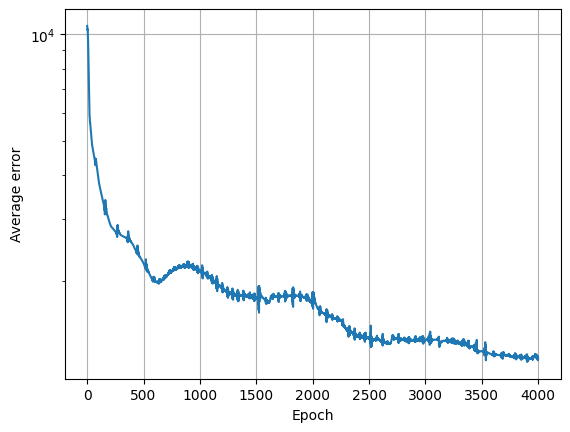

In [37]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(loss_ts)), np.array(loss_ts))
ax.set_ylabel("Average error")
ax.set_xlabel("Epoch")
ax.grid()
ax.set_yscale('log');

Plot an example prediction on the training data

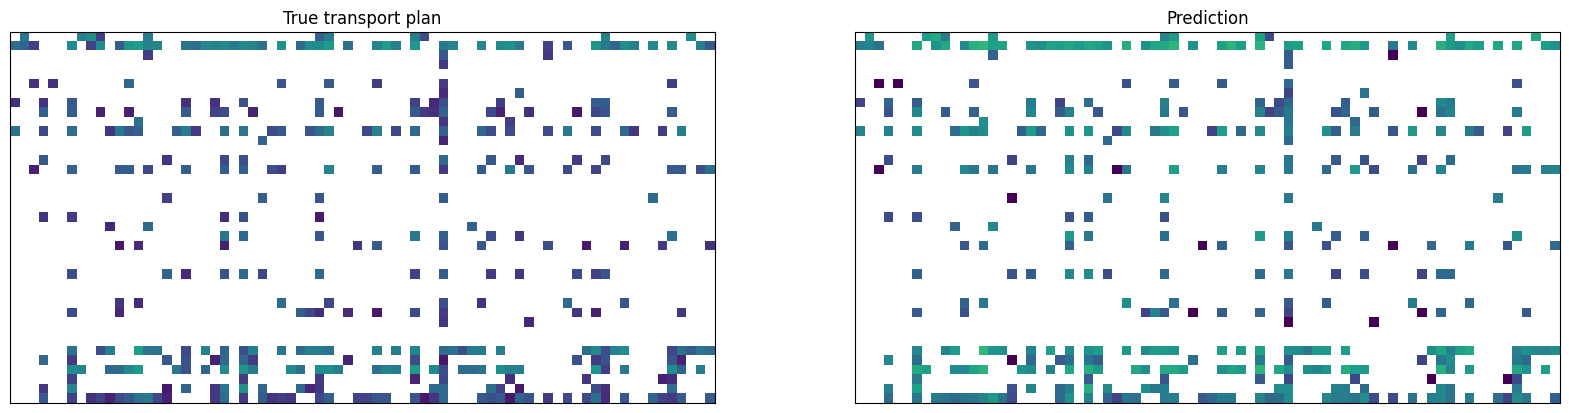

In [38]:
idx = np.random.choice(len(training_data), 1)[0]
example_dset = training_data[idx]
_C_pred = NN(example_dset.reshape(M * N, )).reshape(M, N).detach()

# Get the marginals from the predicted cost matrix
m, n = base.Sinkhorn(
    mu[idx],
    nu[idx],
    _C_pred,
    **sinkhorn_kwargs,
)

_, _, _T_pred = base.marginals_and_transport_plan(m, n, _C_pred, epsilon=sinkhorn_kwargs["epsilon"])


fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
axs[0].imshow(np.ma.masked_where(example_dset == 0, example_dset / 1e6), vmin=0, vmax=example_dset.max(), norm='log')
axs[0].set_title("True transport plan")
axs[1].imshow(np.ma.masked_where(example_dset == 0, _T_pred / 1e6), vmin=0, vmax=example_dset.max(), norm='log')
axs[1].set_title("Prediction");

Plot two example cost matrices

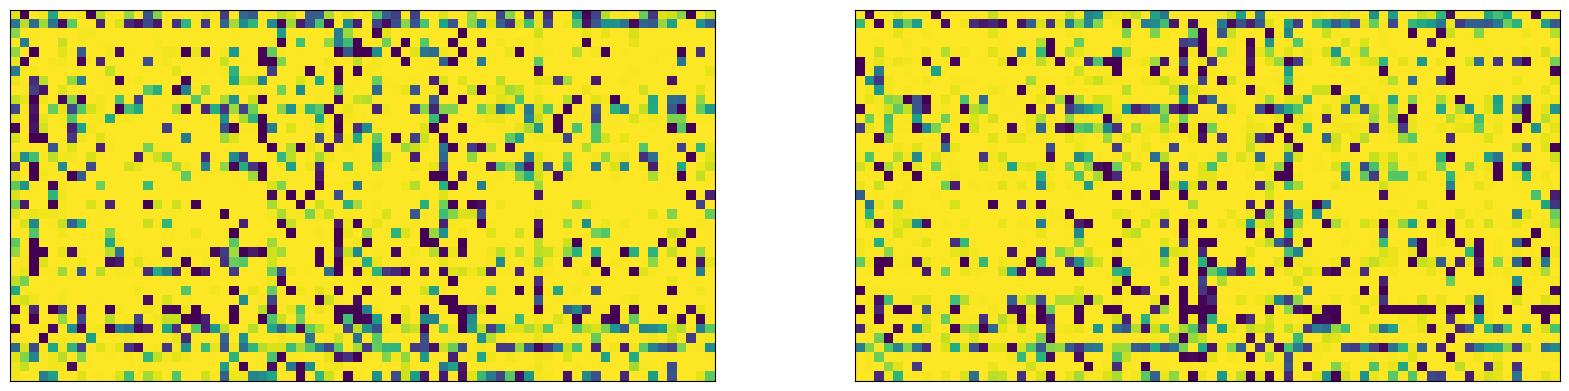

In [39]:
_C_pred_1 = NN(training_data[np.random.choice(len(training_data), 1)[0]].reshape(M * N, )).reshape(M, N).detach()
_C_pred_2 = NN(training_data[np.random.choice(len(training_data), 1)[0]].reshape(M * N, )).reshape(M, N).detach()

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
axs[0].imshow(_C_pred_1, vmin=0, vmax=1)
axs[1].imshow(_C_pred_2, vmin=0, vmax=1);

## 4. Sample

Now generate predictions on the FAOStat data by randomly picking one of the reporter values for each Year, where available. Generating 1000 samples for each of the 20 years takes about 15 minutes.

In [40]:
# Number of samples for each year
N_samples = 1000

# xr.Dataset containing the data
_empty = np.zeros((N_samples, len(FAO_data.coords['Year'].data), M, N))
samples = xr.Dataset(
    data_vars=dict(
        C=(["Sample", "Year", "Source", "Destination"], np.zeros_like(_empty)), 
        T=(["Sample", "Year", "Source", "Destination"], np.zeros_like(_empty)),
        T_pred=(["Sample", "Year", "Source", "Destination"], np.zeros_like(_empty))
    ), 
    coords={"Sample": np.arange(N_samples), 
            "Year": FAO_data.coords["Year"].data, 
            "Source": FAO_data.coords["Source"].data, 
            "Destination": FAO_data.coords["Destination"].data}
)

for j in tqdm(range(N_samples), desc="Sampling"):

    for year in FAO_data.coords['Year'].data:

        # Pick random entries along the 'Reporter' axis and fill NaN values
        _dset = torch.from_numpy(
            np.apply_along_axis(np.random.choice, 0, FAO_data.sel({"Element": "Quantity, t", "Year": year}).data)
        ).float()
        
        _C_pred = NN(_dset.reshape(M * N, )).reshape(M, N).detach()
                
        # Get the marginals from the predicted cost matrix
        m, n = base.Sinkhorn(
            _dset.sum(dim=1, keepdim=True),
            _dset.sum(dim=0, keepdim=True),
            _C_pred,
            **sinkhorn_kwargs,
        )

        _, _, _T_pred = base.marginals_and_transport_plan(m, n, _C_pred, epsilon=sinkhorn_kwargs["epsilon"])
     
        _dset[_dset == 0] = torch.nan
        _C_pred[_dset == 0] = torch.inf

        samples["C"].loc[{"Year": year, "Sample": j}] = _C_pred
        samples["T"].loc[{"Year": year, "Sample": j}] = _dset
        samples["T_pred"].loc[{"Year": year, "Sample": j}] = _T_pred

Sampling: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


## 5. Save the results

In [43]:
# Save the sample statistics
xr.Dataset(dict(mean=samples.to_array().mean("Sample"), std=samples.to_array().std("Sample"))).to_netcdf(f"Samples/{DSET}_samples_stats.nc")

/Users/thomasgaskin/inverse-optimal-transport/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [42]:
# Save the trained NN
# torch.save(NN.state_dict(), "/Users/thomasgaskin/FAOSTAT_data/Bananas/trained_NN.pt")
# NN2 = base.NeuralNet(
#     input_size=M * N,
#     output_size=M * N,
#     num_layers=5,
#     nodes_per_layer=dict(default=60),
#     activation_funcs=dict(default='tanh', layer_specific={-1: 'sigmoid'}),
#     biases=dict(default=None),
#     optimizer='Adam',
#     learning_rate=0.002
# )
# NN2.load_state_dict(torch.load("/Users/thomasgaskin/FAOSTAT_data/Bananas/trained_NN.pt"))